# Modellierung multimodaler Energiesysteme in Pandapipes

Zunächst beginnen wir mit der grundlegenden Modellierung eines Rohrnetzes (z.B. Wasserstoff für Gastransport, Wasser für Wärmetransport) in Pandapipes.

In [1]:
import pandapipes as ppipes

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


      p_bar     t_k
0  5.000000  283.15
1  4.996512  283.15


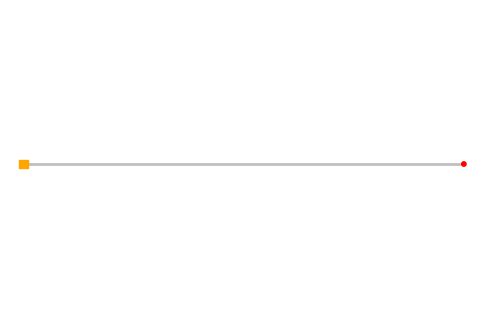

In [2]:
net = ppipes.create_empty_network(name="net")
j1 = ppipes.create_junction(net, pn_bar=5.0, tfluid_k=283.15)
j2 = ppipes.create_junction(net, pn_bar=5.0, tfluid_k=283.15)
p1 = ppipes.create_pipe_from_parameters(net, from_junction=j1, to_junction=j2, length_km=10, diameter_m=0.3)

# Randbedingungen:
eg = ppipes.create_ext_grid(net, junction=j1, p_bar=5, t_k=283.15)
sink = ppipes.create_sink(net, junction=j2, mdot_kg_per_s=0.05)
# Fluid:
ppipes.create_fluid_from_lib(net, "hydrogen", overwrite=True)  # H-Gas, L-Gas, H2, Wasser, ...
# Berechnung:
ppipes.pipeflow(net)
# Ergebnisse:
print(net.res_junction)

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot()
ppipes.plotting.simple_plot(net, ax=ax)
plt.show()

## Datenstrukturen 
Wie die Namen "pandapipes" und "pandapower" andeuten, werden alle Komponenten des Energiesystems in pandas-Dataframes abgelegt. Sehen wir uns zum Beispiel die Rohre und Knoten an:

In [3]:
net.pipe

,name,from_junction,to_junction,std_type,length_km,diameter_m,k_mm,loss_coefficient,alpha_w_per_m2k,text_k,qext_w,sections,in_service,type
0,None,0,1,None,10.0,0.3,0.2,0.0,0.0,293.0,0.0,1,True,pipe


In [4]:
net.junction

,name,pn_bar,tfluid_k,height_m,in_service,type
0,None,5.0,283.15,0.0,True,junction
1,None,5.0,283.15,0.0,True,junction


Wir können die Entwicklung des Druckabfalls z.B. als eine Funktion der Masseentnahme visualisieren.

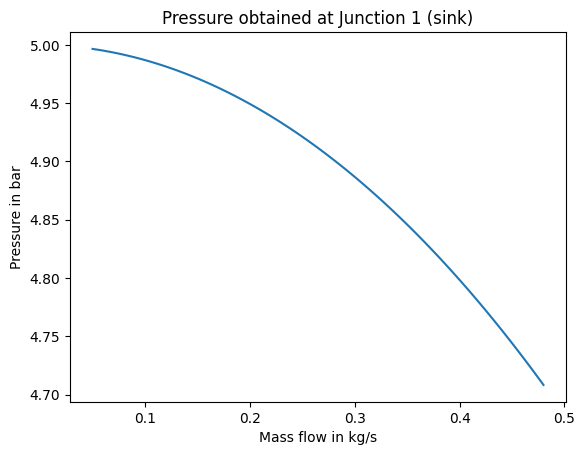

In [5]:
import matplotlib.pyplot as plt
import numpy as np
m_flows = np.linspace(0.05, 0.48, 100)
pressures = []
for m in m_flows:
    # setze die Masseentnahme in das Netzmodell ein - einfaches Pandas-Dataframe Objekt
    net.sink.at[sink, "mdot_kg_per_s"] = m 

    ppipes.pipeflow(net)
    p_junction_0 = net.res_pipe.at[p1, "p_to_bar"]
    pressures.append(p_junction_0)

plt.plot(m_flows, pressures)
plt.xlabel("Mass flow in kg/s")
plt.ylabel("Pressure in bar")
plt.title("Pressure obtained at Junction 1 (sink)")
plt.show()

# Multimodale Netze

Pandapipes ist insbesondere dafür geeignet, multimodale Netze zu entwickeln, d.h. zum Beispiel Kopplungen zwischen Wärmenetz und Stromnetz (Power-to-Heat) oder Gasnetz und Stromnetz (Power-to-Gas, KWK). Die Fluidsystemmodellierung in Pandapipes umfasst dabei Gase und Flüssigkeiten, sowie Hydraulik und Thermodynamik.

Wir wollen folgendes Netz modellieren:

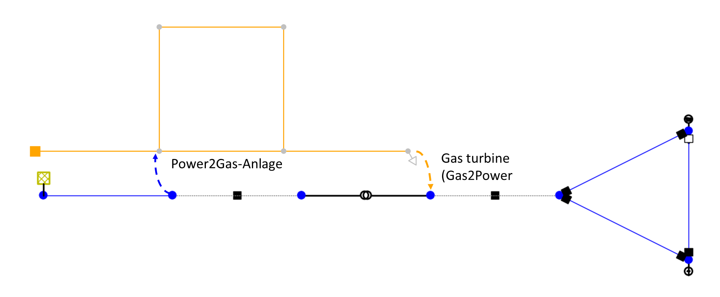

Nach den Imports können hierfür vorbereitete Netze verwendet werden:

In [6]:
from pandapower import networks as e_nw # electrical networks
import pandapipes as ppipes
import pandapower as ppower
from pandapipes import networks as g_nw # gas networks

net_power = e_nw.example_simple()
net_gas = g_nw.gas_meshed_square()

c:\Users\Schiendorfer\Anaconda3\envs\energy\Lib\site-packages\pandapower\io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
c:\Users\Schiendorfer\Anaconda3\envs\energy\Lib\site-packages\pandapower\io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
c:\Users\Schiendorfer\Anaconda3\envs\energy\Lib\site-packages\pandapower\io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=

In [7]:
# some adjustments
net_gas.junction.pn_bar = net_gas.ext_grid.p_bar = 30 # 30 bar for _all_ the junctions, I guess
net_gas.pipe.diameter_m = 0.4

# let's get a fluid
ppipes.create_fluid_from_lib(net_gas, "hydrogen", overwrite=True) ## HHV value is needed for energy conversion

Nun müssen die Kopplungspunkte definiert werden: 

Für die Power-to-Gas Anlage:
* Eine Last im Stromnetz
* Eine Einspeisung (source) im Gasnetz

In [8]:
p2g_id_el = ppower.create_load(net_power, bus=1, p_mw = 2, name="power to gas consumption")
p2g_id_gas = ppipes.create_source(net_gas, junction=2, mdot_kg_per_s=0, name="power to gas feed in")

Für die Gas-to-Power Anlage (z.B. Gasturbine bzw. GuD-Kraftwerk):
* Eine Last im Gasnetz
* Einen Generator im Stromnetz

In [9]:
g2p_id_gas = ppipes.create_sink(net_gas, junction=5, mdot_kg_per_s=0.1, name="gas to power consumption")
g2p_id_el = ppower.create_sgen(net_power, bus=4, p_mw=0, name = "fuel cell feed in")

Nun kann der eigentliche Multi-Net Container eingesetzt werden:

In [10]:
# jetzt kommt der Multinet-Container zum Einsatz - für gekoppelte Netze
from pandapipes.multinet.create_multinet import create_empty_multinet, add_net_to_multinet

multinet = create_empty_multinet("multi-energy-grid")
add_net_to_multinet(multinet, net_power, "power")
add_net_to_multinet(multinet, net_gas, "gas")

Die eigentliche Konversion der Energieformen und die gekoppelte Ausführung des Lastfluss und der Strömungssimulation in Rohren findet in sogenannten Controllern statt. Diese nehmen den Fluss von einer Komponente, verwenden die Umrechnung und passen den Berechnungswert für das jeweils andere Netz an. (z.B. bei Power-to-Gas wird die eingesetzte Leistung in die resultierende Masseeinspeiung umgerechnet und im Gasnetz gesetzt.)

In [11]:
from pandapipes.multinet.control.controller.multinet_control import P2GControlMultiEnergy, G2PControlMultiEnergy
from pandapipes.multinet.control.run_control_multinet import run_control

p2g_ctrl = P2GControlMultiEnergy(multinet, p2g_id_el, p2g_id_gas, efficiency=0.7)
g2p_ctrl = G2PControlMultiEnergy(multinet, g2p_id_el, g2p_id_gas, efficiency=0.65)

Mit dem Befehl `run_control` werden schlussendlich die hydraulischen und elektrischen Simulationen (wiederum mit einem Newton-Raphson-Solver) ausgeführt.

In [12]:
run_control(multinet, numba=False) # startet Lastfluss in pandapower und Rohrfluss in pandapipes
# numba = False, damit Performance-Warnungen ignoriert werden
print(f"Gaseinspeisung durch die Power-to-Gas-Anlage: {net_gas.source.loc[p2g_id_gas, 'mdot_kg_per_s']}")
print(f"Stromeinspeisung durch die Gasturbine (GuD-KW): {net_power.sgen.loc[g2p_id_el, 'p_mw']}")

Gaseinspeisung durch die Power-to-Gas-Anlage: 0.009867771857114663
Stromeinspeisung durch die Gasturbine (GuD-KW): 9.221940000000002


## Visualisierung der Netzzustände in Abhängigkeit der Betriebsweisen der Kopplungspunkte
In dem Beispielnetz sehen wir bei hoher Gaseinspeisung durch Power-to-Gas eine Rückführung ins Verteilnetz, da eine schwache Senke modelliert ist. Wenn die Gasturbine stark fährt, bemerkt man entsprechende Leistungsänderungen im Stromnetz - durch die gekoppelte Simulation des Gesamtnetzes sieht man Zustandsänderung an allen Rohren bzw. Leitungen.

(Code zum Plotten erstmal verborgen)

In [13]:
%matplotlib widget
def draw_net(net_power, net_gas, ax1, ax2):
    ax1.clear()

    net_power.res_line.loc[:, ["p_from_mw", "q_from_mvar", "p_to_mw", "q_to_mvar"]].plot.bar(ax=ax1, title="Power Grid Lines")
    ax1.set_xticks(net_power.res_line.index, net_power.line.loc[:, "name"])
    ax1.set_ylim([-15, 15])

    ax2.clear()
    net_gas.res_pipe.loc[:, ["v_mean_m_per_s",  "mdot_from_kg_per_s"]].plot.bar(ax=ax2, title = "Gas Grid Pipes")
    ax2.set_xticks(net_gas.res_pipe.index, net_gas.pipe.loc[:, "name"])
    ax2.set_ylim([-0.2, 1])

def draw_plot(net_power, net_gas):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))

    #  df.plot.bar(x='Region', rot=0, title='Population', figsize=(15,10), fontsize=12)
    draw_net(net_power, net_gas, ax1, ax2)

    plt.tight_layout()

    from matplotlib.widgets import Button, Slider

    # adjust the main plot to make room for the sliders
    fig.subplots_adjust(bottom=0.35)

    # Make a horizontal slider to control the frequency.
    axmdot = fig.add_axes([0.25, 0.13, 0.65, 0.03])
    mdot_slider = Slider(
        ax=axmdot,
        label='Gas-to-Power: mdot_kg_per_s',
        valmin=0,
        valmax=0.4,
        valinit=0.1
    )

    # Make a horizontal slider to control the frequency.
    # ttuple (left, bottom, width, height)
    axpower = fig.add_axes([0.25, 0.08, 0.65, 0.03])
    power_slider = Slider(
        ax=axpower,
        label='Power-to-Gas: MW',
        valmin=0,
        valmax=15.0,
        valinit=2.0
    )

    # The function to be called anytime a slider's value changes
    def update(val):
        #line.set_ydata(f(t, amp_slider.val, freq_slider.val))
        # recalc 
        net_power.load.at[p2g_id_el, "p_mw"] = power_slider.val
        net_gas.sink.at[g2p_id_gas, "mdot_kg_per_s"] = mdot_slider.val 
        run_control(multinet)
        draw_net(net_power, net_gas, ax1, ax2)

    # register the update function with each slider
    mdot_slider.on_changed(update)
    power_slider.on_changed(update)

    # Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
    resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
    button = Button(resetax, 'Reset', hovercolor='0.975')

    def reset(event):
        mdot_slider.reset()
        
    button.on_clicked(reset)
    plt.show()
    return fig

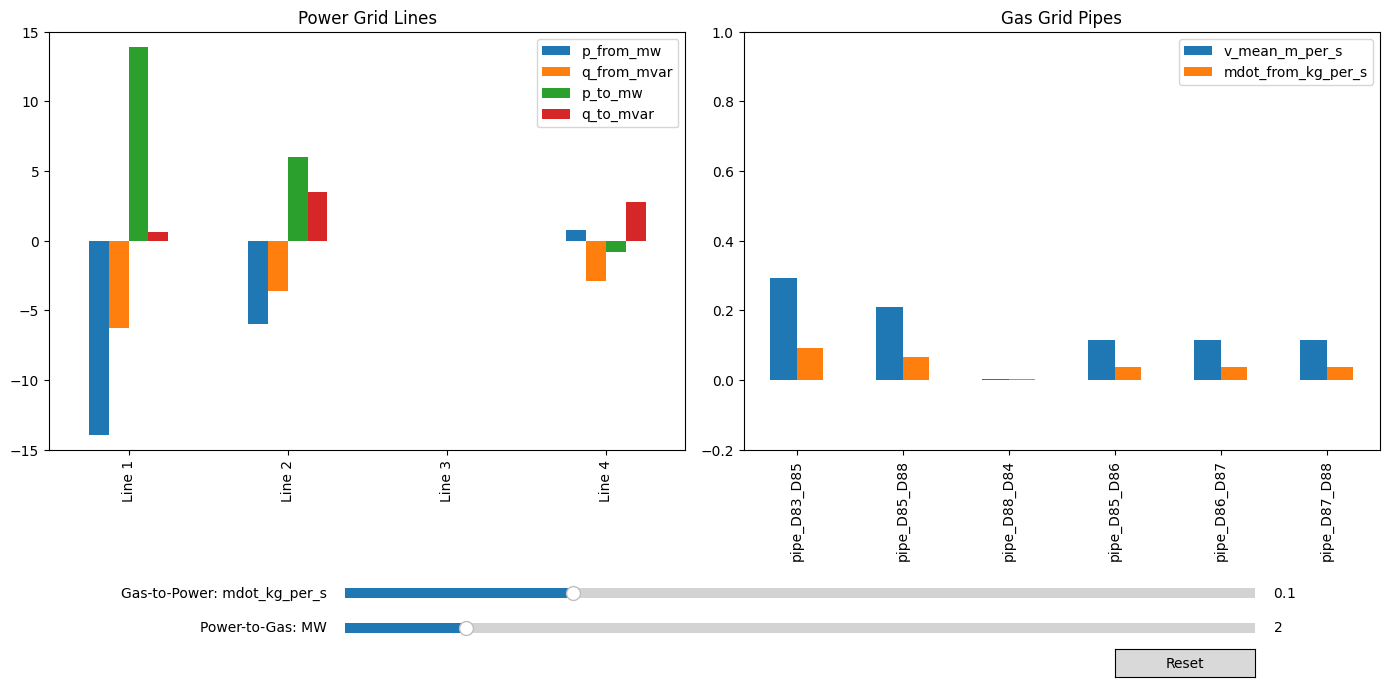

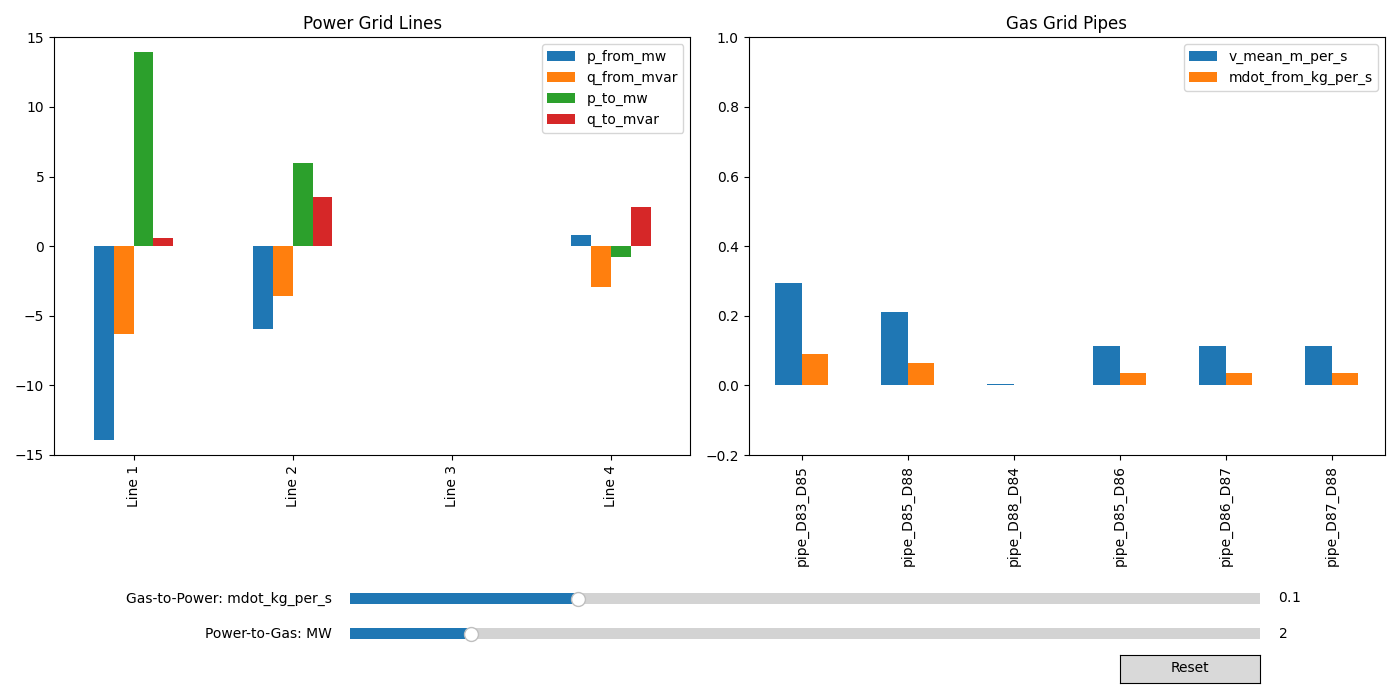

In [14]:
draw_plot(net_power, net_gas    )